In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from functions import *

import statsmodels.nonparametric.api as nparam
from statsmodels.nonparametric.kernel_regression import KernelReg

from scipy.optimize import minimize
from multiprocess import Pool



/Users/lilimatic/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Let $X \sim U[-2,2]$ and 

\begin{equation}
Y_i=a\left\{X_i+2 \exp \left(-16 X_i^2\right)\right\}+\sigma\left(X_i\right) \varepsilon_i
\end{equation}

where $\varepsilon \sim \mathcal{N} \left(0,1\right)$.

The variance function is described by

\begin{equation}
\sigma \left(x \right) = 0.4 \exp \left(-2 x^2\right)+0 \cdot 2
\end{equation}



We estimate the relationship with the Nadaraya-Watson estimator

\begin{equation}
m_{n} \left(x\right) = \frac{
\sum_{i=1}^{n} Y_{i} K \left(
    \frac{x-X_{i} }{h}
    \right)
}{\sum_{i=1}^{n} K \left(
    \frac{x-X_{i} }{h}
    \right)}.
\end{equation}

We assume that the predictor $X$ is missing at random and is observed with the probability of observation
\begin{equation}
\pi \left(Y_i\right) = \frac{1}{1+\exp^{-\left(\beta_{0} +\beta_{1}Y_{i}\right)}}
\end{equation}

that is modelled with the logit function.

If $\pi \left(y \right)$ is known, the Horwitz-Thompson estimator is 
\begin{equation}
m_{n} \left(x\right) = \frac{
\sum_{i=1}^{n} 
\frac{\Omega_{i}Y_{i}}{
\pi \left(Y_{i} \right)
}
 K \left(
    \frac{x-X_{i} }{h}
    \right)
}{\sum_{i=1}^{n} 
\frac{\Omega_{i}}{
\pi \left(Y_{i} \right)
}
K \left(
    \frac{x-X_{i} }{h}
    \right)},
\end{equation}

If  $\pi \left(y \right)$ is unknown, we estimate it with 

In [2]:
#Setting 
#Hyperparameter set-up

n = 10000
h=0.2
a=0.5

b0 = -1
b1 = -1

#Data generation 
X = np.random.uniform(-2,2,n)
X.sort()


eps = eps(0, 1,  n)

y = fan(X,n,a,eps)
omega = bernoulli.rvs(pi(y,b0,b1), size=n)


In [3]:
df = pd.DataFrame({'x':X,'y':y,'omega':omega})

In [4]:
#ipw

df['y_pi'] =  df['y'].apply(lambda t: t/pi(t,b0,b1))

df['var'] = df['x'].apply(lambda t: sigma_reg(t,len(df)))

In [5]:
df_cc = df.loc[df['omega']==1]

In [6]:
model = KernelReg(endog=[df.y],exog=[df.x],reg_type='lc',var_type='c', bw='cv_ls')

model_cc = KernelReg(endog=[df_cc.y],exog=[df_cc.x],reg_type='lc',var_type='c', bw='cv_ls')



In [7]:
model_cc.bw

array([0.06794479])

In [8]:
def r_parallel(h):
    print(1)
    def fn(j):
        df1 = df.drop([j],axis=0)
        y_hat = nw_mis(h,df.x[j],df1.x,df1.y,pi(df1.y,b0,b1),df1.omega)
        return (df.y[j]-y_hat)**2

    with Pool(8) as p:
        return np.mean(p.map(fn, range(len(df))))

In [9]:
%%time
# r_parallel(0.1)
h_ipw = minimize(r_parallel, 0.15).x

1
1
1
1
1
1
1
1
1
1
1
1
CPU times: user 6.01 s, sys: 635 ms, total: 6.64 s
Wall time: 2min 27s


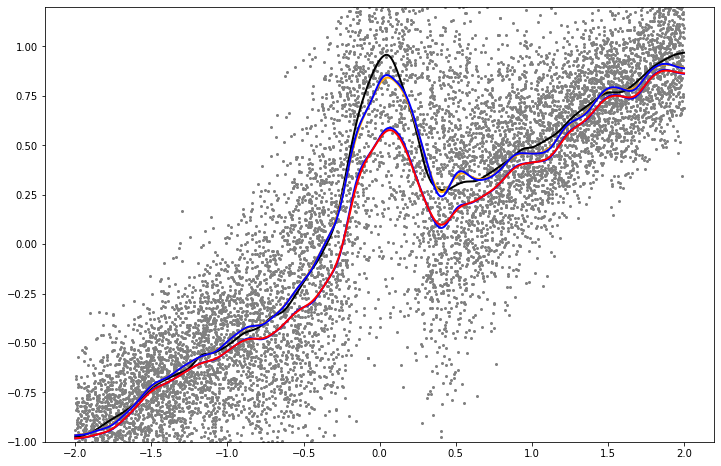

In [21]:
fig, ax = plt.subplots(1, 1,figsize=(12, 8))
ax.plot(df['x'], df['y'], 'o', color='grey',markersize=2)

#ax.plot(df_cc['x'], df_cc['y'], 'o', color='grey',markersize=3)
#NW

ax.plot(np.linspace(-2, 2, n),model.fit(np.linspace(-2, 2, n))[0] ,color= 'black', lw=2,)

ax.plot(np.linspace(-2, 2, n),[nw_mis(model_cc.bw,t,X,y,pi(y,b0,b1),omega) for t in np.linspace(-2, 2, n)],color= 'orange', lw=2)
ax.plot(np.linspace(-2, 2, n),[nw_mis(h_ipw,t,X,y,pi(y,b0,b1),omega) for t in np.linspace(-2, 2, n)],color= 'blue', lw=2)
#ax.plot(np.linspace(-2, 2, n),[nw_mis(model.bw,t,X,y,pi(y,b0,b1),omega) for t in np.linspace(-2, 2, n)],'--',color= 'red', lw=2)

ax.plot(np.linspace(-2, 2, n),[nw_cc(h_ipw,t,X,y,pi(y,b0,b1),omega) for t in np.linspace(-2, 2, n)],color= 'blue', lw=2)


ax.plot(np.linspace(-2, 2, n),model_cc.fit(np.linspace(-2, 2, n))[0] ,color= 'red', lw=2)

#Sanity check
#ax.plot(np.linspace(-2, 2, n),[nw_cc(model_cc.bw,t,X,y,pi(y,b0,b1),omega) for t in np.linspace(-2, 2, n)],color= 'black', lw=2)

ax.set_ylim(-1,1.2)


plt.savefig(f'Fixed Cross-Validated Regression.pdf',transparent=True)




In [16]:
h_ipw

array([0.05944642])

In [17]:
model.bw

array([0.04795456])

In [18]:
model_cc.bw

array([0.06794479])